In [2]:
import torch
from IPython.display import display
import torchvision as tv
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image
from random import randint
import collections
!pip install torchviz
import torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=f4202b24ad71d5fe191b9cc0e1f61908c3af81106f990f5d2d1cda5fd117bc06
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [3]:
new_shape = (28, 28)
# transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Resize(new_shape)])
imagenet_data_back = tv.datasets.Omniglot('/content/sample_data/Omniglot', download=True, background=True)
imagenet_data_eval = tv.datasets.Omniglot('/content/sample_data/Omniglot', download=True, background=False)
# data_train = tv.datasets.ImageFolder('/content/sample_data/Omniglot/omniglot-py/images_background',transform=transform)
# data_test = tv.datasets.ImageFolder('/content/sample_data/Omniglot/omniglot-py/images_evaluation',transform=transform)
# train_data = torch.utils.data.DataLoader(data_train, batch_size=4)
# test_data = torch.utils.data.DataLoader(data_test, batch_size=4)


Extracting /content/sample_data/Omniglot/omniglot-py/images_background.zip to /content/sample_data/Omniglot/omniglot-py



Extracting /content/sample_data/Omniglot/omniglot-py/images_evaluation.zip to /content/sample_data/Omniglot/omniglot-py


In [4]:
def image_array(home, im_path, new_shape):
    path = os.path.join(home, im_path)
    main_list = os.listdir(path)
    image_list_main = []
    for folder in main_list:
        char_list = os.listdir(os.path.join(path, folder))
        image_list_folder = []
        for char in char_list:
            img_list = os.listdir(os.path.join(path, folder, char))
            image_list_char = []
            for img in img_list:
                img_arr = Image.open(os.path.join(path, folder, char, img))
                img_arr.thumbnail(new_shape, Image.ANTIALIAS) 
                img_arr = np.asarray(img_arr, dtype=np.float) 
                image_list_char.append(img_arr)
            image_list_folder.append(image_list_char)
        image_list_main.append(np.asarray(image_list_folder))
    return image_list_main
home = '/content/sample_data'
path1 = 'Omniglot/omniglot-py/images_background'
path2 = 'Omniglot/omniglot-py/images_evaluation'
imgs_train = image_array(home, path1, new_shape)
imgs_test = image_array(home, path2, new_shape)

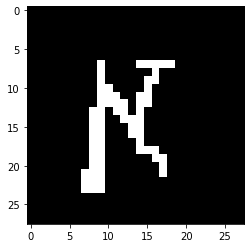

In [5]:
plt.imshow(imgs_train[0][1][2], cmap='Greys')
#plt.imshow(imgs_test[0][1][2], cmap='Greys')

In [1]:
def create_dataset(imgs, ways, shots, tasks):
    main_list_x = []
    main_list_y = []
    for task in range(tasks):
        task_list_x = []
        task_list_y = []
        for way in range(ways):
            no_langs = len(imgs)
            lang = randint(0, no_langs-1)
            no_chars = imgs[lang].shape[0]
            char = randint(0, no_chars-1)
            no_imgs = imgs[lang][char].shape[0]
            for img in range(shots):
                img_no = randint(0, no_imgs-1)
                cur_img = imgs[lang][char][img_no]
                task_list_x.append(cur_img,)
                task_list_y.append(way)
        size = shots*ways
        indices = np.random.choice(size, size, replace=False)
        task_list_x = np.array(task_list_x)
        task_list_y = np.array(task_list_y)
        task_list_x = task_list_x[indices]
        task_list_y = task_list_y[indices]
        main_list_x.append(task_list_x)
        main_list_y.append(task_list_y)
    return np.array(main_list_x), np.array(main_list_y)

Counter({4: 10, 2: 10, 0: 10, 3: 10, 1: 10})
4


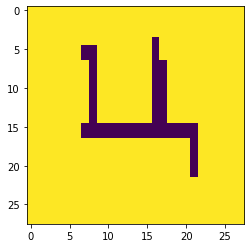

In [6]:
data_train_x, data_train_y = create_dataset(imgs_train, 5, 10, 10)
data_test_x, data_test_y = create_dataset(imgs_test, 5, 10, 10)
print(collections.Counter(data_train_y[1]))
plt.imshow(data_train_x[0][3])
print(data_train_y[0][3])

In [8]:
class neural_network(torch.nn.Module):
    def __init__(self, feature_size=28*28, hidden_size= 200, ways = 0, shots = 0, mem=(128, 40)):
        super(neural_network, self).__init__()
        self.l1 = torch.nn.LSTM(input_size = feature_size + ways, hidden_size = hidden_size)
        self.d0 = torch.nn.Linear(feature_size + ways, hidden_size)
        self.d1 = torch.nn.Linear(hidden_size+mem[-1], 512)
        self.d2 = torch.nn.Linear(512, 256)
        self.d3 = torch.nn.Linear(256, 64)
        self.d4 = torch.nn.Linear(64, ways)
        self.k1 = torch.nn.Linear(hidden_size, mem[-1])
        self.feature_size = feature_size
        self.ways = ways
        self.shots = shots
        self.hidden_size = hidden_size
        self.stored_dataset = None
        self.alpha = torch.rand((1), requires_grad=True)
        self.mem = mem

    def backprop(self, Y, labels):
        criterion = torch.nn.NLLLoss()
        loss = criterion(Y, labels)
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.99)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    def forward(self, xy, g, MANN, LSTM):
        train_loss = 0
        memory = torch.rand(self.mem)
        wlu = torch.ones((memory.size()[0], 1))
        wr = torch.rand((memory.size()[0], 1))
        ww = torch.rand((memory.size()[0], 1))
        wu = torch.rand((memory.size()[0], 1))
        y_lstm_h_1,  y_lstm_c_1 = torch.zeros((1,1,self.hidden_size)), torch.zeros((1,1,self.hidden_size))
        k_sm_wu = 1e-9
        Y = torch.empty((0, self.ways), dtype=float)
        for no, timesteps in enumerate(xy):
            if LSTM:
                op, (y_lstm_h_1,  y_lstm_c_1) = self.l1(timesteps.unsqueeze(0), (y_lstm_h_1,  y_lstm_c_1))
            else:
                y_lstm_h_1 = self.d0(timesteps.unsqueeze(0))
            if MANN:
                key = y_lstm_c_1.squeeze()
                key_final = self.k1(key).unsqueeze(0)
                key_final_norm = torch.sqrt(torch.sum(torch.square(key_final)))
                memory_norm = torch.sqrt(torch.sum(torch.square(memory), dim = 1))
                dist_prod = (key_final_norm* memory_norm)
                #write
                ww = self.alpha*wr + (1-self.alpha)*wlu
                memory = memory +ww@key_final
                #read
                z = memory@(key_final.permute((1,0)))
                z = (z.squeeze()/dist_prod).unsqueeze(1)
                wr = torch.nn.functional.softmax(z, dim=0)
                rt = wr.permute((1,0))@memory
                #least recently used
                wu = g*wu + wr + ww
                k_sm_wu = wu.squeeze().sort().values[3] #CHECK
                wlu = torch.tensor([1 if x< k_sm_wu else 0 for x in wu.squeeze()]).unsqueeze(1)
            else:
                rt = torch.zeros((1, memory.size()[-1]))
            y_lstm_1_last = torch.cat((y_lstm_h_1.squeeze(), rt.squeeze()))
            y_d1 = torch.nn.functional.relu(self.d1(y_lstm_1_last))
            y_d2 = torch.nn.functional.relu(self.d2(y_d1))
            y_d3 = torch.nn.functional.relu(self.d3(y_d2))
            y_d4 = torch.nn.functional.relu(self.d4(y_d3))
            pred = torch.nn.functional.log_softmax(y_d4, dim=-1).unsqueeze(0)
            Y = torch.cat((Y, pred))
        return Y

    def one_episode (self, data, task_creator, MANN, LSTM, update_dataset = True, train=True):
        if self.stored_dataset == None and not update_dataset:
            self.stored_dataset = task_creator(imgs_train, self.ways, self.shots, 1)
        if update_dataset:
            self.stored_dataset = task_creator(imgs_train, self.ways, self.shots, 1)
        data_train_x, data_train_y = self.stored_dataset
        data_train_x = torch.from_numpy(data_train_x)
        data_train_y = torch.from_numpy(data_train_y)
        y_prev = torch.tensor([0])
        y_test = data_train_y[0]
        X = torch.empty((0, self.feature_size + self.ways))
        for index, curr_x in enumerate(data_train_x[0]):
            y_prev_henc = torch.eye(self.ways)
            y_prev_henc = y_prev_henc[y_prev].squeeze()
            flattened_x = curr_x.reshape(-1)
            curr_X = torch.cat((flattened_x, y_prev_henc)).reshape(1, -1)
            X = torch.cat((X, curr_X))
            y_prev = data_train_y[0][index: index+1]
        X = torch.unsqueeze(X, 1)
        X = X.float()
        pred = self.forward(X, 0.99, MANN, LSTM)
        if train:
            train_loss = self.backprop(pred, y_test) 
            episode_loss = train_loss/pred.size()[0]
        return X, y_test, pred, episode_loss if train else None

    def accuracy(self, y_pred, labels):
        prev_labels = {}
        acc_dict = {}
        y_pred = y_pred.detach().numpy()
        labels = labels.detach().numpy()
        for index, label in enumerate(labels):
            pred_dec = np.argmax(y_pred[index]).item()
            label_dec = labels[index]
            if prev_labels.get(label_dec, None)  != None:
                prev_labels[label_dec] += 1
                if pred_dec == label_dec:
                    acc_dict[label_dec].append(1)
                else:
                    acc_dict[label_dec].append(0)
            else:
                prev_labels[label_dec] = 1
                if pred_dec == label_dec:
                    acc_dict[label_dec] = [1]
                else:
                    acc_dict[label_dec] = [0]
        return acc_dict

nn = neural_network(ways = 5, shots = 10)

In [ ]:
no_epochs = 100000
show_after = 100
for epoch in range(no_epochs):
    x, y, pred, loss = nn.one_episode(imgs_train, create_dataset,update_dataset=True, MANN=True, LSTM=True)
    if epoch%show_after == 0:
        print(loss.item())

tensor([1., 0.]) [0.49184742 0.50815261]
tensor([0., 1.]) [0.49159442 0.50840558]
tensor([1., 0.]) [0.49529438 0.50470562]
tensor([1., 0.]) [0.49099941 0.50900057]
tensor([0., 1.]) [0.48839437 0.51160564]
tensor([0., 1.]) [0.49076034 0.50923964]
tensor([1., 0.]) [0.48886575 0.51113421]
tensor([0., 1.]) [0.48850919 0.51149081]
tensor([0., 1.]) [0.4884215  0.51157853]
tensor([0., 1.]) [0.49570121 0.50429879]
tensor([1., 0.]) [0.49418631 0.5058137 ]
tensor([1., 0.]) [0.49198994 0.50801006]
tensor([1., 0.]) [0.4884627  0.51153734]
tensor([0., 1.]) [0.48822041 0.51177964]
tensor([0., 1.]) [0.49452142 0.50547858]
tensor([1., 0.]) [0.49361585 0.50638417]
tensor([1., 0.]) [0.49090524 0.50909478]
tensor([0., 1.]) [0.49234699 0.50765301]
tensor([1., 0.]) [0.49158845 0.50841158]
tensor([0., 1.]) [0.49420136 0.50579862]


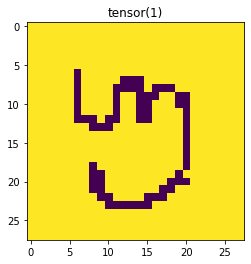

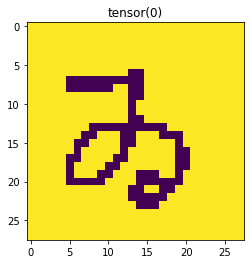

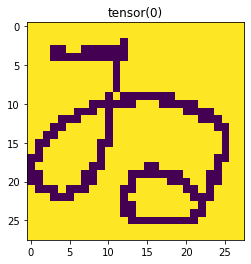

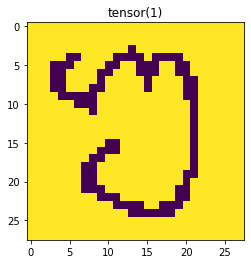

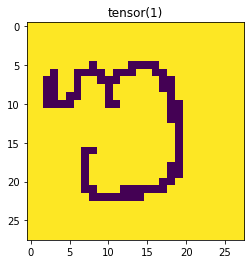

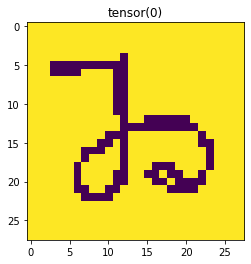

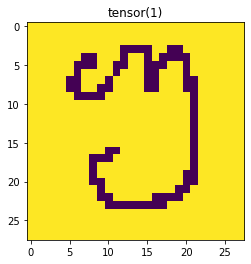

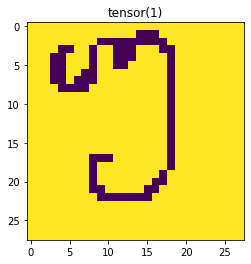

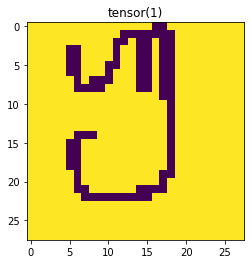

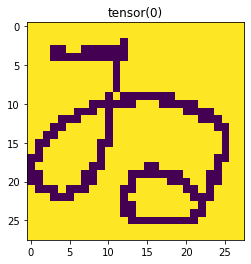

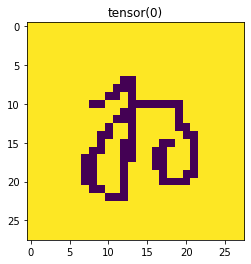

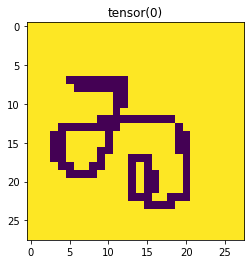

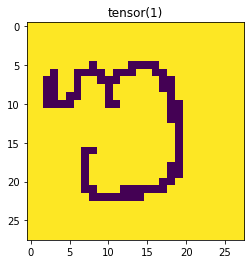

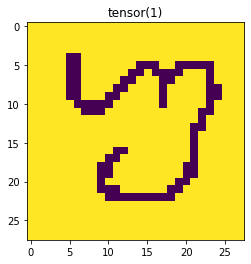

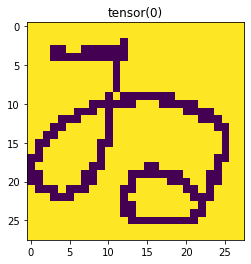

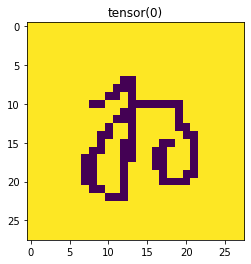

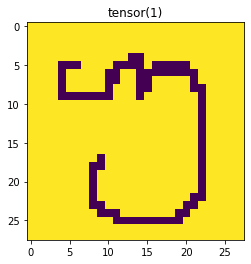

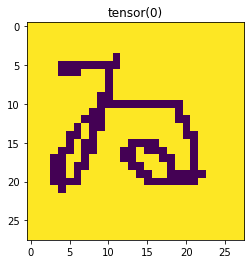

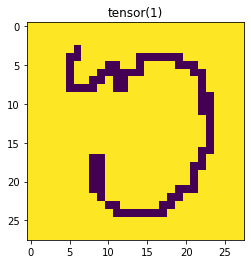

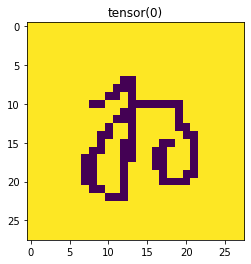

In [404]:
for index, element in enumerate(x.squeeze()):
    X = element.squeeze()[0:784].reshape(28,28)
    y_prev = element.squeeze()[784:].reshape(-1)
    print(y_prev, np.exp(pred[index].detach().numpy()))
    fig, ax = plt.subplots()
    ax.imshow(X)
    ax.set_title(y[index])

In [360]:
x, y, pred, loss = nn.one_episode(imgs_train, create_dataset,update_dataset=False, train = False, MANN=False, LSTM=True)
nn.accuracy(pred, y)

{0: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [381]:
class neural_network(torch.nn.Module):
    def __init__(self, feature_size=28*28, hidden_size= 200, ways = 0, shots = 0, mem=(128, 40)):
        super(neural_network, self).__init__()
        self.d1 = torch.nn.Linear(feature_size+ways, hidden_size)
        self.d2 = torch.nn.Linear(hidden_size, 512)
        self.d3 = torch.nn.Linear(512, 64)
        self.d4 = torch.nn.Linear(64, ways)
        self.k1 = torch.nn.Linear(hidden_size, mem[-1])
        self.feature_size = feature_size
        self.ways = ways
        self.shots = shots
        self.hidden_size = hidden_size
        self.stored_dataset = None
        self.alpha = torch.rand((1), requires_grad=True)
        self.mem = mem

    def backprop(self, Y, labels):
        criterion = torch.nn.NLLLoss()
        loss = criterion(Y, labels)
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.999)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    def forward(self, xy):
        Y = torch.empty((0, self.ways), dtype=float)
        for no, timesteps in enumerate(xy):
            y_d1 = torch.nn.functional.relu(self.d1(timesteps))
            y_d2 = torch.nn.functional.relu(self.d2(y_d1))
            y_d3 = torch.nn.functional.relu(self.d3(y_d2))
            y_d4 = torch.nn.functional.relu(self.d4(y_d3))
            pred = torch.nn.functional.log_softmax(y_d4, dim=-1)
            Y = torch.cat((Y, pred))
        return Y

    def one_episode (self, data, task_creator, update_dataset = True, train=True):
        if self.stored_dataset == None and not update_dataset:
            self.stored_dataset = task_creator(imgs_train, self.ways, self.shots, 1)
        if update_dataset:
            self.stored_dataset = task_creator(imgs_train, self.ways, self.shots, 1)
        data_train_x, data_train_y = self.stored_dataset
        data_train_x = torch.from_numpy(data_train_x)
        data_train_y = torch.from_numpy(data_train_y)
        y_prev = torch.tensor([0])
        y_test = data_train_y[0]
        X = torch.empty((0, self.feature_size + self.ways))
        for index, curr_x in enumerate(data_train_x[0]):
            y_prev_henc = torch.eye(self.ways)
            y_prev_henc = y_prev_henc[y_prev].squeeze()
            flattened_x = curr_x.reshape(-1)
            curr_X = torch.cat((flattened_x, y_prev_henc)).reshape(1, -1)
            X = torch.cat((X, curr_X))
            y_prev = data_train_y[0][index: index+1]
        X = torch.unsqueeze(X, 1)
        X = X.float()
        pred = self.forward(X)
        if train:
            train_loss = self.backprop(pred, y_test) 
            episode_loss = train_loss/pred.size()[0]
        return X, y_test, pred, episode_loss if train else None

    def accuracy(self, y_pred, labels):
        prev_labels = {}
        acc_dict = {}
        y_pred = y_pred.detach().numpy()
        labels = labels.detach().numpy()
        for index, label in enumerate(labels):
            pred_dec = np.argmax(y_pred[index]).item()
            label_dec = labels[index]
            if prev_labels.get(label_dec, None)  != None:
                prev_labels[label_dec] += 1
                if pred_dec == label_dec:
                    acc_dict[label_dec].append(1)
                else:
                    acc_dict[label_dec].append(0)
            else:
                prev_labels[label_dec] = 1
                if pred_dec == label_dec:
                    acc_dict[label_dec] = [1]
                else:
                    acc_dict[label_dec] = [0]
        return acc_dict

nn = neural_network(ways = 2, shots = 10)


In [382]:
for epochs in range(1000):
    x, y, pred, loss = nn.one_episode(imgs_train, create_dataset,update_dataset=False)
    if epochs%100 == 0:
        print(loss)

tensor(0.0347, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0347, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0347, dtype=torch.float64, grad_fn=<DivBackward0>)


KeyboardInterrupt: ignored

In [348]:
print(y, torch.argmax(pred, axis = 1))

tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]) tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0])
